In [ ]:
import numpy as np
import pandas as pd

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from tqdm.notebook import tqdm as tqdm

import plotly.graph_objs as go #visualization library
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation test
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #stationarity test
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from datetime import datetime, timedelta
import statsmodels.api as sm
import gc
from pylab import rcParams
import random
import os
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import gc
import lightgbm as lgb
import time
import numpy as np
import pandas as pd
import os
import time
import matplotlib.dates as mdates
import gc
import lightgbm as lgb
import time
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
import multiprocessing as mp
import warnings
warnings.filterwarnings("ignore")
import datetime

%matplotlib inline

#from sklearn.metrics import mean_squared_error
#from statsmodels.tsa.seasonal import seasonal_decompose
#import statsmodels.api as sm
#import calendar

In [2]:
#pip install fbprophet

# Data Preparation

In [4]:
import plotly.io as pio
pio.templates["draft"] = go.layout.Template(
    layout_annotations=[
        dict(
            textangle=-30,
            opacity=0.1,
            font=dict(color="black", size=100),
            xref="paper",
            yref="paper",
            x=0.5,
            y=0.5,
            showarrow=False,
        )
    ]
)
pio.templates.default = "draft"

In [5]:
path = 'm5-forecasting-accuracy/'

In [6]:
train_sales = pd.read_csv(path+'sales_train_validation.csv')
calendar = pd.read_csv(path+'calendar.csv')
sell_prices = pd.read_csv(path+'sell_prices.csv')

In [7]:
train_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [29]:
# d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29 to 2016-06-19.

train_sales


,id,item_id,dept_id,cat_id,store_id,state_id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [30]:
train_sales.isnull().sum().sort_values(ascending = False)


id            0
2014-07-21    0
2014-08-02    0
2014-08-01    0
2014-07-31    0
             ..
2012-10-19    0
2012-10-18    0
2012-10-17    0
2012-10-16    0
2016-04-24    0
Length: 1919, dtype: int64

In [10]:
states = train_sales.state_id.unique().tolist()

In [11]:
states


In [12]:
stores = train_sales.store_id.unique().tolist()

In [13]:
stores
hide_toggle()

In [14]:
categories = train_sales.cat_id.unique().tolist()

In [15]:
categories
hide_toggle()

In [16]:
items = train_sales.dept_id.unique().tolist()

In [17]:
items
hide_toggle()

In [18]:
train_sales.item_id.unique()
hide_toggle()

In [18]:
print(f'There are {len(train_sales.item_id.unique())} Items in the Dataset')

There are 3049 Items in the Dataset


In [19]:
import datetime
x = datetime.date(2011,1,29)
for c in ((train_sales.columns)[6:]):
    train_sales.rename(columns={c:x},inplace=True)
    x = x + datetime.timedelta(days=1)

The datasets was gotten from the M5 competition on kaggle.

The M5 was from March 2, 2020 to June 30 of the same year. 

# The datasets: 
 The M5 dataset, generously made available by Walmart, involves the unit sales of various products sold in the USA, organized in the form of grouped time series

In [35]:

# This contains the historical daily unit sales data per product and store.

# item_id: The id of the product.

# dept_id: The id of the department the product belongs to.

# cat_id: The id of the category the product belongs to.

# store_id: The id of the store where the product is sold.

# state_id: The State where the store is located.

# d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29.

train_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [32]:
# This Contains information about the dates the products are sold.

# date: The date in a “y-m-d” format.

# wm_yr_wk: The id of the week the date belongs to.

# weekday: The type of the day (Saturday, Sunday, …, Friday).

# wday: The id of the weekday, starting from Saturday.

# month: The month of the date.

# year: The year of the date.

#snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 
#1 indicates that SNAP purchases are allowed.

#The United States federal government provides a nutrition assistance benefit called the Supplement Nutrition Assistance Program (SNAP). 
#SNAP provides low income families and individuals with an Electronic Benefits Transfer debit card to purchase food products

calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [34]:
# This contains information about the price of the products sold per store and date.

# store_id: The id of the store where the product is sold.

# item_id: The id of the product.

# wm_yr_wk: The id of the week.

# sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). 
# If not available, this means that the product was not sold during the examined week. 
#Note that although prices are constant at weekly basis, they may change through time (both training and test set).





sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# This shows the Sales of first 5 items as time series

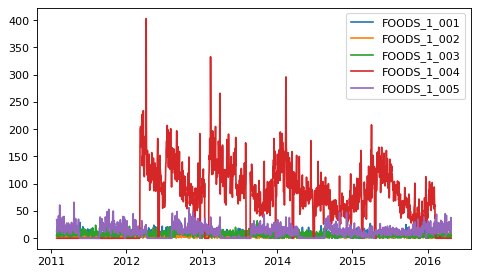

In [22]:
# Sales of first 5 items as time series

X = train_sales.groupby('item_id')[(train_sales.columns)[6:]].sum()

plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
for i in range(5):
    plt.plot(X.iloc[i,:],label=X.index[i])
    plt.legend(loc='best')
plt.show()


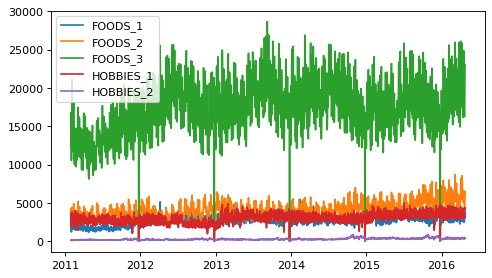

In [23]:
X = train_sales.groupby('dept_id')[(train_sales.columns)[6:]].sum()

plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
for i in range(5):
    plt.plot(X.iloc[i,:],label=X.index[i])
    plt.legend(loc='best')
plt.show()

In [24]:
X
hide_toggle()

# This shows the total sales as time series

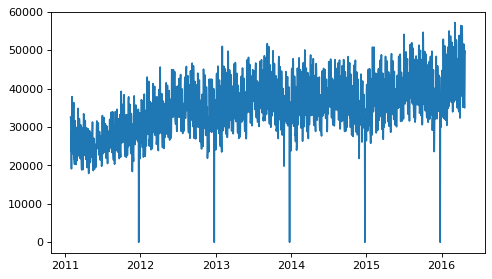

In [23]:
# Total sales as time series

plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
(X.sum()).plot()
plt.show()

# This shows that we have data with 10 stores and 3049 items per store so as a result we have 30490 time series.

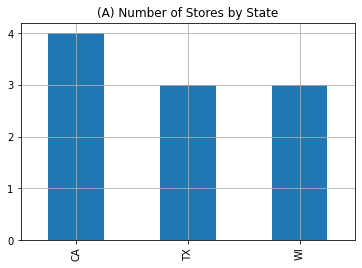

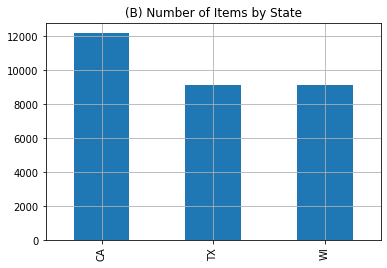

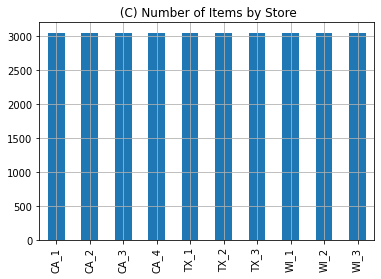

In [26]:
d = train_sales.groupby(['state_id','store_id']).count().reset_index()
d['state_id'].value_counts().plot(kind="bar", grid=True, title="(A) Number of Stores by State", yticks=[0,1,2,3,4])
plt.show()

d = train_sales.groupby(['state_id','id']).count().reset_index()
d['state_id'].value_counts().plot(kind="bar", grid=True, title="(B) Number of Items by State")
plt.show()

d = train_sales.groupby(['store_id','item_id']).count().reset_index()
d['store_id'].value_counts().plot(kind="bar", grid=True, title=" (C) Number of Items by Store")
plt.show()



# This shows the category distribution

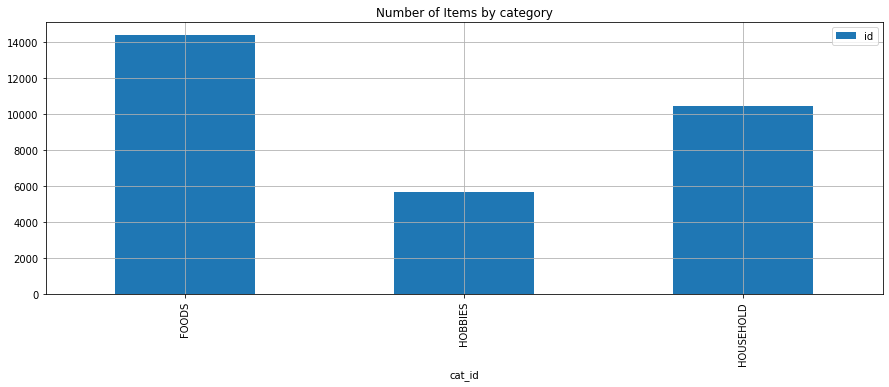

In [27]:
train_sales.groupby('cat_id').count()['id'].reset_index().plot(x = 'cat_id', kind = 'bar', figsize = (15, 5), grid = True, title = 'Number of Items by category')
plt.show()

# This further shows how the different categories are further divided

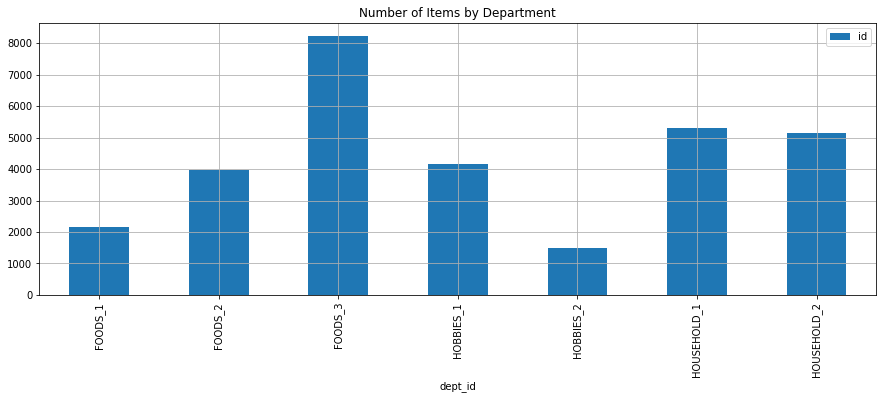

In [28]:
train_sales.groupby('dept_id').count()['id'].reset_index().plot(x='dept_id', kind='bar', figsize=(15,5), grid=True, title='Number of Items by Department')
plt.show()

In [41]:
# Monthly sales in different cities

X = train_sales
X = X.groupby(X.columns.map(lambda x : x if type(x) == str else x.strftime('%Y-%m')),axis=1).sum()


In [42]:
X

,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,...,2016-01,2016-02,2016-03,2016-04,cat_id,dept_id,id,item_id,state_id,store_id
0,0,0,0,0,0,0,0,0,0,0,...,24,29,29,26,HOBBIES,HOBBIES_1,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,CA,CA_1
1,0,0,0,0,0,3,5,10,7,8,...,4,5,10,1,HOBBIES,HOBBIES_1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,CA,CA_1
2,0,0,0,0,0,0,0,0,0,0,...,6,9,15,16,HOBBIES,HOBBIES_1,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,CA,CA_1
3,0,0,17,23,34,28,60,55,53,55,...,64,60,53,51,HOBBIES,HOBBIES_1,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,CA,CA_1
4,0,0,0,0,31,31,5,36,67,26,...,22,33,39,29,HOBBIES,HOBBIES_1,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,CA,CA_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,2,86,127,94,55,30,27,20,27,29,...,24,21,7,6,FOODS,FOODS_3,FOODS_3_823_WI_3_validation,FOODS_3_823,WI,WI_3
30486,0,32,41,29,19,12,37,24,22,21,...,0,0,0,9,FOODS,FOODS_3,FOODS_3_824_WI_3_validation,FOODS_3_824,WI,WI_3
30487,6,131,85,40,29,32,41,0,2,39,...,24,19,35,24,FOODS,FOODS_3,FOODS_3_825_WI_3_validation,FOODS_3_825,WI,WI_3
30488,0,0,0,0,0,0,0,0,0,0,...,47,27,36,23,FOODS,FOODS_3,FOODS_3_826_WI_3_validation,FOODS_3_826,WI,WI_3


In [43]:
for c in ((X.columns)[:-6]):
    x= datetime.datetime.strptime(c, '%Y-%m').date()
   # X.rename(columns={c:x},inplace=True)

In [44]:
x

datetime.date(2016, 4, 1)

# This shows the different time series distribution for the different 3 states. Clearly there is an upward trend over the years.

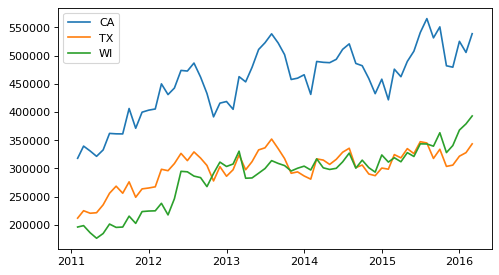

In [27]:
F = X.groupby(['state_id'])[(X.columns)[:-6]].sum()
plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(F.iloc[i,1:-1],label=F.index[i])
    plt.legend(loc='best')
plt.show()

# This shows the different time series for the different categories. Food takes is sold most, followed by household and then hobbies

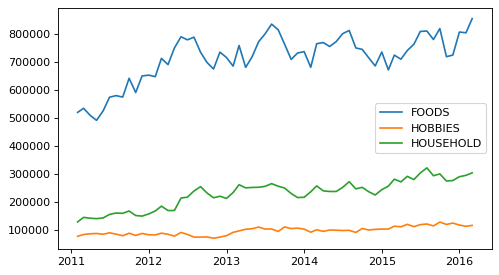

In [28]:
#Monthly sales at different categories


F = X.groupby(['cat_id'])[(X.columns)[:-6]].sum()
plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(F.iloc[i,1:-1],label=F.index[i])
    plt.legend(loc='best')
plt.show()

# This is further broken down to the differnt stores in the differnt states

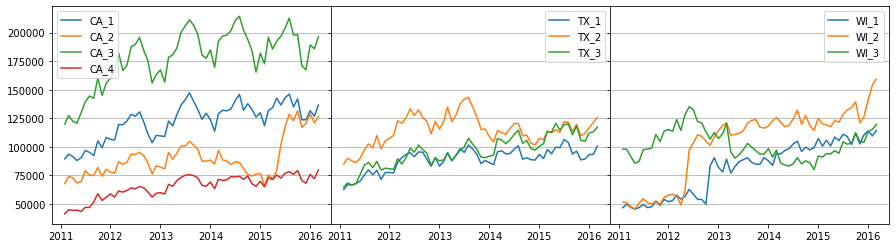

In [30]:
# Monthly sales at different stores

F = X.groupby(['store_id'])[(X.columns)[:-6]].sum()
fig, ax = plt.subplots(1, 3, sharey=True, figsize = (15,4))
for i in range(10):
    n = lambda x : 0 if x == 'C' else (1 if x == 'T' else 2)
    n = n(F.index[i][0])
    ax[n].plot(F.iloc[i,1:-1],label=F.index[i])
    ax[n].grid(b=True,axis='y')
    ax[n].legend(loc='best')
fig.subplots_adjust( wspace=0.0)
plt.show()

In [33]:
# smoothing with fit

F = train_sales.drop(labels=[datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)],axis=1)

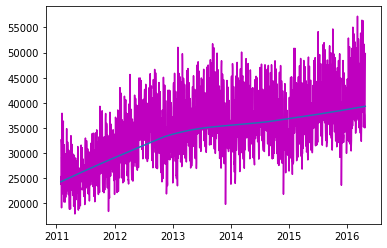

In [34]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
S = F.iloc[:,6:].sum()
z = lowess(S.values, range(S.shape[0]))
plt.plot(S,color='m')
plt.plot(pd.Series(z[:,1],S.index))

# This shows the sales per state with seasonality

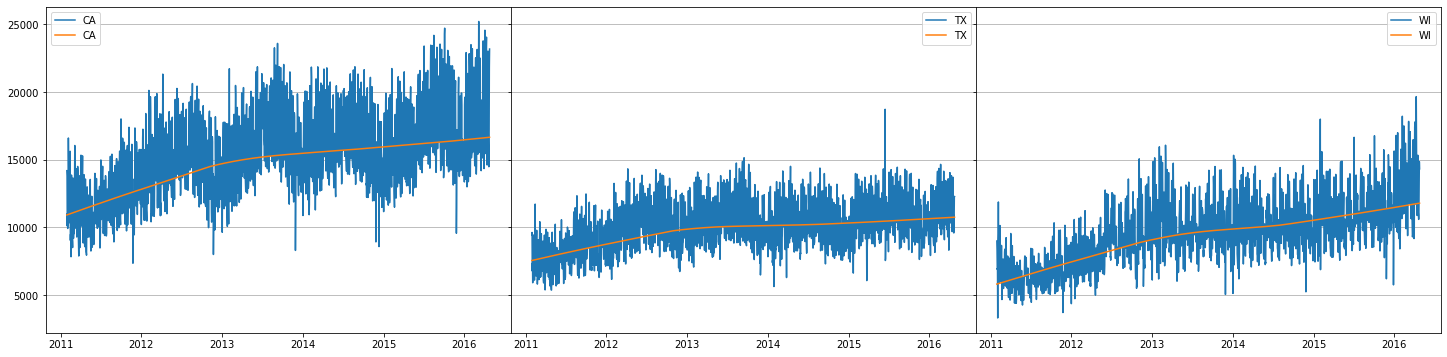

In [35]:
# sales per state with seasonality
M = F.groupby(['state_id'])[(F.columns)[6:]].sum()

fig, ax = plt.subplots(1, 3, sharey=True, figsize = (25,6))

for i in range(3):
    ax[i].plot(M.iloc[i,:],label=M.index[i])
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    ax[i].plot(pd.Series(z[:,1],M.columns),label=M.index[i])
    ax[i].grid(b=True,axis='y')
    ax[i].legend(loc='best')

fig.subplots_adjust( wspace=0.0)
plt.show()

In [37]:
mean_sales = F.iloc[:,6:].sum().mean()

# This show the weekly seasonality in the 3 states averaged over the years

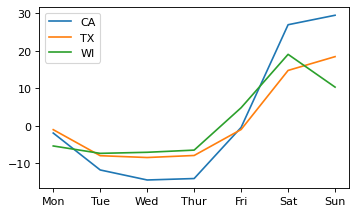

In [38]:
# weekly seasonality
A = M
for i in range(3):
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    A.iloc[i,:] = M.iloc[i,:] - z[:,1]
A = A/mean_sales
A = A.groupby(A.columns.map(lambda x : str(x.weekday())),axis=1).sum()
plt.figure(num=None, figsize=(5, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(A.iloc[i,:],label=A.index[i])
    plt.xticks(range(0,7),['Mon', 'Tue', 'Wed', 'Thur', 'Fri','Sat','Sun' ])
    plt.legend(loc='best')
plt.show()

# This shows the monthly seasonality of the 3 states averaged over the years

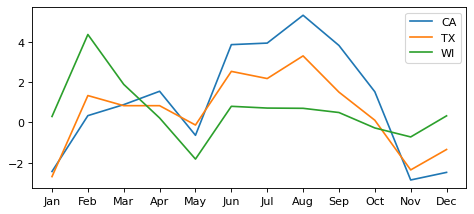

In [39]:
# monthly seasonality
A = M
for i in range(3):
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    A.iloc[i,:] = M.iloc[i,:] - z[:,1]
A = A/mean_sales
A = A.groupby(A.columns.map(lambda x : (x.month)),axis=1).sum()
plt.figure(num=None, figsize=(7,3), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(A.iloc[i,:],label=A.index[i])
    plt.legend(loc='best')
    plt.xticks(range(1,13),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()